In [1]:

import torch 
from ebm_pkg.models import get_model
from ebm_pkg.datasets import get_datasets
from ebm_pkg.ebm.sampler import Sampler
import numpy as np 
import matplotlib.pyplot as plt 
from omegaconf import OmegaConf
from ebm_pkg.datasets import CIFAR10_MEAN, CIFAR10_STD, MNIST_MEAN, MNIST_STD

data='mnist'
data_path='untracked'
# ---- Load Dataset -----
train_dataset, valid_dataset = get_datasets(data, data_path=data_path)

# ----- Load EBM / Sampler -----
checkpoint= 1000
path = f"../results/ebm/{data}/cnn/seed_1/checkpoint_{checkpoint}"
flags = OmegaConf.load(f"{path}/config.yaml")

configs = {
    "cnn" : (1, flags.activation, flags.cnn_dim, None), 
    "resnet18" : (1, flags.activation, flags.cnn_dim, flags.avg_pool_size)
}
out_features, activation, cnn_dim, last_avg_kernel_size = configs[flags.model]
ebm_model = get_model(flags.model, 
                in_channels=flags.in_channels,
                out_features=out_features,
                activation=activation,
                cnn_dim=cnn_dim,
                last_avg_kernel_size=last_avg_kernel_size)
ebm_model.load_state_dict( torch.load(f"{path}/model.pt"))
sampler = Sampler(flags.img_size, flags.maxlen)
sampler.load(f"{path}/buffer.pt")

# ----- Load Classifier -----
loss="baseline"
checkpoint=0
path = f"../results/train/{data}/{loss}/seed_0/checkpoint_{checkpoint}"
flags = OmegaConf.load(f"{path}/config.yaml")

configs = {
    "cnn" : (flags.num_classes, 'relu' , flags.cnn_dim, None), 
    "resnet18" : (flags.num_classes, 'relu', flags.cnn_dim, flags.avg_pool_size)
}
out_features, activation, cnn_dim, last_avg_kernel_size = configs[flags.model]
model = get_model(flags.model, 
                in_channels=flags.in_channels,
                out_features=out_features,
                activation=activation,
                cnn_dim=cnn_dim,
                dropout_p = flags.dropout_p,
                last_avg_kernel_size=last_avg_kernel_size)
model.load_state_dict(torch.load(f"{path}/model.pt"))

cnn
cnn


<All keys matched successfully>

In [2]:
def convert_to_img(tensor, means, stds):
    means = torch.tensor(means).view(len(means), 1,1)
    stds = torch.tensor(stds).view(len(means), 1,1)
    img = (tensor * stds) + means
    img = img.permute(1,2,0).numpy()
    img = img*255
    img = img.astype(int)
    img = img.clip(0,255)
    return img 

means = CIFAR10_MEAN if 'cifar' in flags.data else MNIST_MEAN
stds = CIFAR10_STD if 'cifar' in flags.data else MNIST_STD

# Generate Fake Samples 

100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


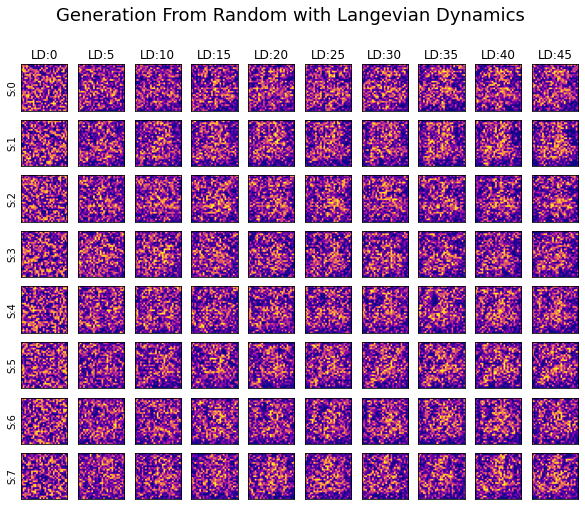

In [3]:
batch_size = 8
np.random.seed(50)
fake_init = sampler.sample(batch_size=batch_size, random=True)
# Run Langevain Dynamics
lagevian_steps = 50
lagevian_step_size = 20
neg_samples, _, buffer, _= sampler.langevian_dynamics(ebm_model, fake_init, lagevian_steps=lagevian_steps, lagevian_step_size=lagevian_step_size,  return_dynamics=True, verbose=True)

N = batch_size
D = 10
plot_steps = lagevian_steps //D
ratio = 1.0
fig, axes = plt.subplots(N, D, figsize=(D*ratio, N*ratio))
fig.suptitle("Generation From Random with Langevian Dynamics", fontsize=18)
axes = axes.flat

for s in range(N):
    for i in range(D):
        k = plot_steps * i 
        sample=buffer[s,k]
        ax = next(axes)
        img = convert_to_img(sample, means, stds)
        ax.imshow(img, cmap='plasma')
        ax.set_xticks([])
        ax.set_yticks([])
        if s ==0:
            ax.set_title(f'LD:{k}')
        if i==0:
            ax.set_ylabel(f"S:{s}")

# Computation of Logit's Entropy for Negative Samples

Buffer Size: torch.Size([8, 51, 1, 28, 28])
Reshaped Buffer Size: torch.Size([408, 1, 28, 28])
Logit Size: torch.Size([408, 10])


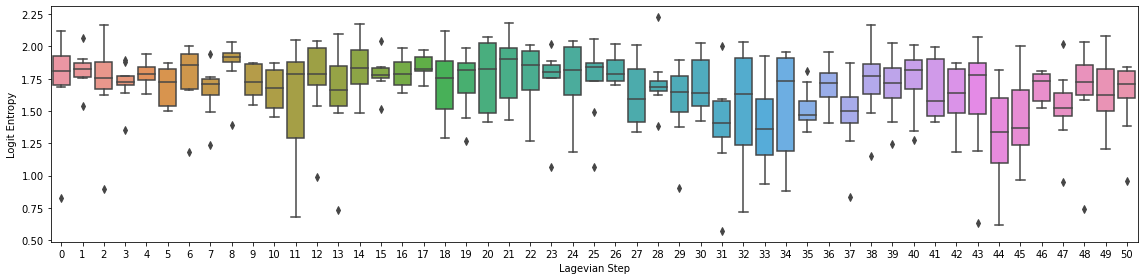

In [17]:
from ebm_pkg.loss import compute_entropy
import seaborn as sns 
model.eval()
size = buffer.size()
print("Buffer Size:", buffer.size())
buffer_temp = buffer.reshape(-1, 1,28,28)
print("Reshaped Buffer Size:", buffer_temp.size())
logits = model(buffer_temp)
print("Logit Size:", logits.size())
entropy = compute_entropy(logits)
entropy = entropy.reshape(size[0], size[1])

plt.figure(figsize=(16, 4))
sns.boxplot(entropy.detach().numpy())
plt.xlabel("Lagevian Step")
plt.ylabel("Logit Entropy")
plt.tight_layout()
plt.show()

# Computation of Logit's Entropy for Positive Samples

torch.Size([80, 1, 28, 28])
Logit Size: torch.Size([80, 10])


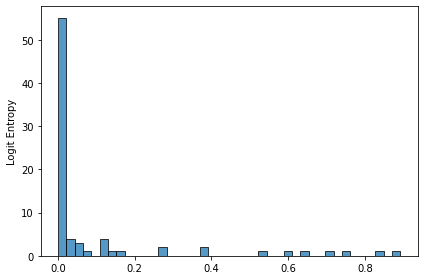

In [31]:
pos_samples = torch.stack([valid_dataset[i][0] for i  in range(80)])
print(pos_samples.size())

logits = model(pos_samples)
print("Logit Size:", logits.size())
entropy = compute_entropy(logits)

# plt.figure(figsize=(16, 4))
sns.histplot(entropy.detach().numpy())
plt.ylabel("Logit Entropy")
plt.tight_layout()
plt.show()